# The Habitual Action Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that maximise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward

/Users/Ethan/miniconda3/envs/tf_daif_car_race/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:61: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

all_observations = []
all_observations_scaled = []
actions = []
rewards = []
num_episodes = 1

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

t_max = 1000

for i in range(num_episodes):
    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o_scaled = transform_observations(o, observation_max, observation_min, obs_stddev)
    o_scaled = o
    actions.append(a)

    rewards.append(r)

    # o = transform_observations(o, observation_max, observation_min, [0, 0])

    all_observations_scaled.append(o_scaled)
    all_observations.append(o[:-1])

all_observations = np.vstack(all_observations)
all_observations_scaled = np.vstack(all_observations_scaled)
actions = np.vstack(actions)
rewards = np.vstack(rewards).T
# rewards = rewards.reshape(rewards.shape[0])
print(all_observations.shape, actions.shape, rewards.shape)

(359, 2) (359, 1) (359, 1)


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
all_observations

array([[-5.13285875e-01,  0.00000000e+00],
       [-5.13546526e-01, -2.60699220e-04],
       [-5.14065981e-01, -5.19444351e-04],
       [-5.14840305e-01, -7.74295244e-04],
       [-5.14604509e-01,  2.35817584e-04],
       [-5.13360322e-01,  1.24416256e-03],
       [-5.11117160e-01,  2.24318006e-03],
       [-5.07891774e-01,  3.22538358e-03],
       [-5.03708363e-01,  4.18341858e-03],
       [-4.98598248e-01,  5.11012273e-03],
       [-4.92599666e-01,  5.99858817e-03],
       [-4.85757440e-01,  6.84222346e-03],
       [-4.78122622e-01,  7.63481669e-03],
       [-4.69752014e-01,  8.37059598e-03],
       [-4.60707724e-01,  9.04429331e-03],
       [-4.51056540e-01,  9.65119805e-03],
       [-4.40869331e-01,  1.01872096e-02],
       [-4.30220455e-01,  1.06488829e-02],
       [-4.19186980e-01,  1.10334633e-02],
       [-4.07848060e-01,  1.13389120e-02],
       [-3.96284133e-01,  1.15639176e-02],
       [-3.84576231e-01,  1.17078992e-02],
       [-3.72805238e-01,  1.17709897e-02],
       [-3.

In [5]:
act_net = HabitualAction(2, 1, [100])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 z_mean (Dense)              (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(rewards.shape)

(359, 1)


In [7]:
cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
cum_rewards.shape

(359, 1)

In [8]:
a_mean = act_net(all_observations, training=True)  # Forward pass

# print(a_mean, true_actions)
a_mean

<tf.Tensor: shape=(359, 1), dtype=float32, numpy=
array([[-0.1135347 ],
       [-0.11359641],
       [-0.11371482],
       [-0.11388907],
       [-0.11381971],
       [-0.11352929],
       [-0.11301989],
       [-0.11229531],
       [-0.11136086],
       [-0.11022338],
       [-0.10889126],
       [-0.10737427],
       [-0.10568358],
       [-0.10383159],
       [-0.10183187],
       [-0.09969898],
       [-0.09744848],
       [-0.09509667],
       [-0.09266043],
       [-0.09015719],
       [-0.08760461],
       [-0.08502056],
       [-0.08242285],
       [-0.07982919],
       [-0.07725693],
       [-0.07472301],
       [-0.07224376],
       [-0.06983491],
       [-0.06751135],
       [-0.06528717],
       [-0.06317551],
       [-0.06118858],
       [-0.05933762],
       [-0.05763282],
       [-0.05608335],
       [-0.0546974 ],
       [-0.05348212],
       [-0.05244367],
       [-0.05158724],
       [-0.050917  ],
       [-0.05043621],
       [-0.05014718],
       [-0.05005131],
    

In [9]:
"""
log_loss = log_likelihood_gaussian(a_mean, actions, 0.05**2, use_consts=False)
weighted_log_loss = log_loss * cum_rewards

print(log_loss)
print(weighted_log_loss)

# need to multiply by negative one because neural net does gradient descent not ascent
neg_weighted_log_loss = -1 * weighted_log_loss
print(neg_weighted_log_loss)"""

'\nlog_loss = log_likelihood_gaussian(a_mean, actions, 0.05**2, use_consts=False)\nweighted_log_loss = log_loss * cum_rewards\n\nprint(log_loss)\nprint(weighted_log_loss)\n\n# need to multiply by negative one because neural net does gradient descent not ascent\nneg_weighted_log_loss = -1 * weighted_log_loss\nprint(neg_weighted_log_loss)'

In [10]:
act_net.fit(all_observations, (actions, cum_rewards), batch_size=all_observations.shape[0], epochs=100)

act_net.train_on_batch(all_observations, (actions, cum_rewards))

Epoch 1/100
1/1 [==============================] - 0s 95ms/step - loss: 847084032.0000
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 827702272.0000
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 809365120.0000
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 792078656.0000
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 775927040.0000
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 760910656.0000
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 747022976.0000
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 734296448.0000
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 722747840.0000
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 712366080.0000
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 703081792.0000
Epoch 12/100
1/1 [==============================] -

2022-09-14 08:48:56.777349: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 2ms/step - loss: 633011840.0000
Epoch 56/100
1/1 [==============================] - 0s 1ms/step - loss: 632401152.0000
Epoch 57/100
1/1 [==============================] - 0s 1ms/step - loss: 631785984.0000
Epoch 58/100
1/1 [==============================] - 0s 1ms/step - loss: 631160064.0000
Epoch 59/100
1/1 [==============================] - 0s 1ms/step - loss: 630524800.0000
Epoch 60/100
1/1 [==============================] - 0s 1ms/step - loss: 629882496.0000
Epoch 61/100
1/1 [==============================] - 0s 1ms/step - loss: 629237504.0000
Epoch 62/100
1/1 [==============================] - 0s 1ms/step - loss: 628593280.0000
Epoch 63/100
1/1 [==============================] - 0s 1ms/step - loss: 627948608.0000
Epoch 64/100
1/1 [==============================] - 0s 1ms/step - loss: 627309120.0000
Epoch 65/100
1/1 [==============================] - 0s 1ms/step - loss: 626692032.0000
Epoch 66/100
1/1 [==============================] - 0s 1

604618496.0

## How about multiple runs?

In [11]:
act_net = HabitualAction(2, 1, [16, 16])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                48        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 z_mean (Dense)              (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [12]:
t_max = 1000
num_episodes = 250

min_reward_cutoff = -1000
min_reward_set = -0.5

time_ratio = 6

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []



    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    o = transform_observations(o, observation_max, observation_min, obs_stddev)
    actions.append(a[::time_ratio])
    rewards.append(r[::time_ratio])

    all_observations.append(o[:-1][::time_ratio])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards).T
    rewards[rewards < min_reward_cutoff] = min_reward_set

    # print(rewards)

    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
    # cum_rewards

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

-146491.515625
16766468.0
36342264.0
-3647216.75
92663584.0
-7673185.0
-46238.984375
-101827.203125
-2328899.75
-171696.375
-512491.125
-25400.70703125
-5036316.0
-579942.8125
-157624.359375
-770750.125
-3581893.0
-1207065.25
-968992.125
73184528.0
-1098254.0
-4638197.5
-7409953.0
-3631489.5
-442068.40625
-50867.55078125
-1061311.25
-31853.4375
-2968352.0
-2675527.25
-28182.34765625
-152714.46875
16229075.0
62088208.0
-3263839.0
-4121411.5
12899346.0
-1978424.75
-105133.4609375
-1602824.25
-4357497.0
-2294988.0
-210828.328125
-1630939.875
-59796.921875
-2497409.5
-341889.875
-1570079.0
-6195612.0
-6419609.5
-234546.40625
-3645447.75
-210748.8125
44306200.0
-63046.4609375
-5118973.5
-747654.5
-1881772.375
-708192.625
84964032.0
-1826465.75
-1395500.25
-1422326.0
-130659.8046875
-3338247.5
-361895.59375
174707616.0
-5633940.0
-762204.625
-1862335.75
-109321.15625
-2739320.75
15031196.0
-5528070.0
-104208.1015625
-1041457.1875
-28529.39453125
-5906103.0
-4059777.5
-147499.75
133246208.0
-

In [13]:
act_net(all_observations)

<tf.Tensor: shape=(167, 1), dtype=float32, numpy=
array([[ 0.00137719],
       [-0.03506977],
       [-0.09583501],
       [-0.15004933],
       [-0.18524504],
       [-0.20675956],
       [-0.2080642 ],
       [-0.14052409],
       [-0.05672495],
       [ 0.04219217],
       [ 0.12943083],
       [ 0.12467262],
       [ 0.09676488],
       [ 0.06395061],
       [ 0.00636475],
       [-0.09212526],
       [-0.22460315],
       [-0.25854275],
       [-0.25312862],
       [-0.29982874],
       [-0.3218468 ],
       [-0.13712966],
       [-0.02519338],
       [ 0.09471273],
       [ 0.15181418],
       [ 0.12971589],
       [ 0.09462697],
       [ 0.04783626],
       [-0.05136312],
       [-0.13979834],
       [-0.20952521],
       [-0.24364121],
       [-0.24696419],
       [-0.25266665],
       [-0.16153876],
       [-0.00668939],
       [ 0.13265328],
       [ 0.13963658],
       [ 0.11152083],
       [ 0.07588601],
       [ 0.04119289],
       [-0.04084128],
       [-0.12423386],
    

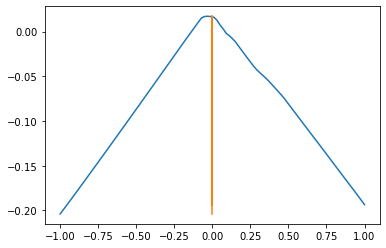

In [14]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.36814272]
 [-0.3621675 ]
 [-0.35616237]
 [-0.3501276 ]
 [-0.34406364]
 [-0.33797088]
 [-0.3318497 ]
 [-0.32570037]
 [-0.3195234 ]
 [-0.31331915]
 [-0.3070881 ]
 [-0.3008921 ]
 [-0.29478046]
 [-0.2886446 ]
 [-0.28246254]
 [-0.27598616]
 [-0.26948458]
 [-0.26295844]
 [-0.25640798]
 [-0.249834  ]
 [-0.24323687]
 [-0.2366172 ]
 [-0.22997546]
 [-0.22331223]
 [-0.21662804]
 [-0.2099235 ]
 [-0.20319918]
 [-0.19645561]
 [-0.1896934 ]
 [-0.18291317]
 [-0.17611548]
 [-0.16930096]
 [-0.16247022]
 [-0.15562384]
 [-0.14876248]
 [-0.141989  ]
 [-0.13524489]
 [-0.12848826]
 [-0.12171961]
 [-0.1149397 ]
 [-0.10814901]
 [-0.10134826]
 [-0.09451859]
 [-0.0876319 ]
 [-0.07845389]
 [-0.06761023]
 [-0.0556803 ]
 [-0.04325357]
 [-0.01948036]
 [ 0.00532511]
 [ 0.02580495]
 [ 0.04052487]
 [ 0.04746983]
 [ 0.05309787]
 [ 0.05934475]
 [ 0.06528239]
 [ 0.07072699]
 [ 0.07530557]
 [ 0.07939651]
 [ 0.08329673]
 [ 0.08541843]
 [ 0.08753478]
 [ 0.08965035]
 [ 0.09176512]
 [ 0.09387906]
 [ 0.09599216]

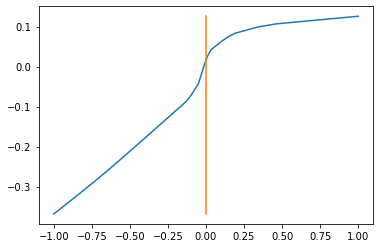

In [15]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [16]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See

KeyboardInterrupt: 

## How about multiple runs on-policy?

In [55]:
act_net = HabitualAction(2, 1, [16, 16], action_std_dev=1)

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_17 (Dense)            (None, 16)                48        
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 z_mean (Dense)              (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [56]:
t_max = 1000
num_episodes = 250

min_reward_cutoff = -1000
min_reward_set = -0.5

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    done = False

    obs = env.reset()

    t = 0
    while not done:

        # env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        all_observations.append(obs)

        action = act_net(obs)
        action = action.numpy() + np.random.normal(0, scale=act_net.action_std_dev)

        obs, reward, done, info = env.step(action)
        actions.append(action)

        t += 1

        # # add reward for finishing fast
        # if done:
        #     # print(t_max - t - 1)
        #     reward += (t_max - t - 1)

        rewards.append(reward)


    # # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o = transform_observations(o, observation_max, observation_min, obs_stddev)
    # actions.append(a)
    # rewards.append(r)
    #
    # all_observations.append(o[:-1])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards)
    # rewards[rewards < min_reward_cutoff] = min_reward_set

    # print(rewards)

    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

-31429162.0
-22054574.0
-24312812.0
-22701090.0
-25818762.0
-24415754.0
-21870970.0
-22389612.0
-21912294.0
-25415426.0
-25007714.0
-26038362.0
-25909366.0
-24977230.0
-24686104.0
-24493184.0
-25421222.0
-25083162.0
-22497246.0
-24128390.0
-26036312.0
-23114434.0
-25529572.0
-25574532.0
16369114.0
-23587152.0
-26197778.0
-22799930.0
-24198636.0
-20027492.0
-26374562.0
-25644482.0
19078768.0
13156012.0
-24894392.0
13313312.0
-26204520.0
-25595914.0
23093796.0
13733202.0
-23697480.0
13997578.0
-18914024.0
-21446606.0
-22442172.0
-24098146.0
-23245064.0
-23164560.0
-28230666.0
-27403796.0
16897604.0
-29555354.0
-23474328.0
-26352746.0
20749464.0
-23321482.0
-26578364.0
18021090.0
-27788294.0
-23540864.0
-24974702.0
-27299996.0
-26072002.0
23267956.0
-23346488.0
-26160250.0
11869044.0
-24066590.0
-25241506.0
-24464642.0
7635612.0
20034324.0
18788476.0
-22309798.0
23728012.0
10084959.0
12001236.0
-23125864.0
7149408.0
23413634.0
-25070284.0
21814564.0
13182464.0
-31172410.0
20632020.0
-2519

In [57]:
act_net(all_observations)

<tf.Tensor: shape=(496, 1), dtype=float32, numpy=
array([[ 5.32272346e-02],
       [ 4.33051139e-02],
       [ 2.23418754e-02],
       [ 2.23374157e-03],
       [-1.15923444e-02],
       [-2.50927676e-02],
       [-5.17909639e-02],
       [-3.30695659e-02],
       [-1.07632456e-02],
       [ 1.31081063e-02],
       [ 3.75856124e-02],
       [ 2.02567019e-02],
       [ 3.32279205e-02],
       [ 3.57214622e-02],
       [ 2.58758888e-02],
       [ 3.21223810e-02],
       [ 3.14206034e-02],
       [ 1.47012146e-02],
       [ 1.66733619e-02],
       [ 4.24095280e-02],
       [ 2.63145361e-02],
       [ 5.23211993e-02],
       [ 5.51650152e-02],
       [ 6.15355000e-02],
       [ 4.97864410e-02],
       [ 4.68276627e-02],
       [ 5.88869378e-02],
       [ 6.47791103e-02],
       [ 4.85554002e-02],
       [ 5.75402342e-02],
       [ 7.08535090e-02],
       [ 6.24923222e-02],
       [ 8.02022815e-02],
       [ 9.12597924e-02],
       [ 7.87335858e-02],
       [ 1.03411160e-01],
       [ 1.016

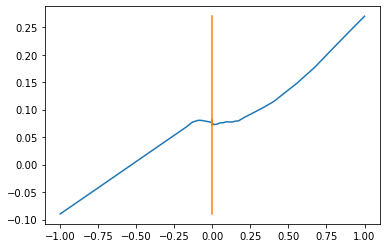

In [58]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

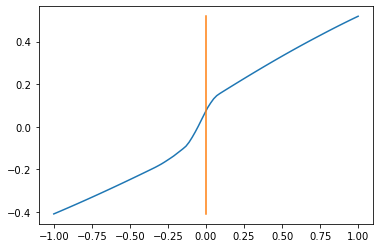

In [59]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [60]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        t += 1

        if t == t_max:
            done = True

        # if done:
        #     reward += (t_max - t - 1)/10

        rewards.append(reward)

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See

340
success
97.87453557970385
335
success
97.91800052737099
318
success
98.39182923132114
367
success
97.95529127594628
282
success
98.44106089966927
320
success
98.21074113829803
281
success
98.32079799661555


KeyboardInterrupt: 

In [13]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-0.409816  ],
       [-0.4060031 ],
       [-0.40266117],
       ...,
       [ 0.5045513 ],
       [ 0.50988096],
       [ 0.5151719 ]], dtype=float32)>

In [16]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

487
success
98.98275621807879
638
success
99.02124489004768
600
success
98.97602046874589
411
success
99.05211472935432
999
success
-0.771943426626886
413
success
98.96669828092982
412
success
99.0555378774882
552
success
98.66005544578006
641
success
98.89805458119318
559
success
98.62563614372343


In [13]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-0.409816  ],
       [-0.4060031 ],
       [-0.40266117],
       ...,
       [ 0.5045513 ],
       [ 0.50988096],
       [ 0.5151719 ]], dtype=float32)>

In [115]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


array([[-1.  , -1.  ],
       [-1.  , -0.98],
       [-1.  , -0.96],
       ...,
       [ 0.98,  0.94],
       [ 0.98,  0.96],
       [ 0.98,  0.98]])

In [101]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X

array([[-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],